In [1]:
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import sklearn
import numpy as np
import torch
from torchvision import datasets
import torch.nn as nn #this submodule provides tools for building and training neural networks
import torch.optim as optim #this submodule contains information on optimizers such as SGD
import os

# Load CIFAR-10 dataset
dataset = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())

# Train and validation split
train_size = len(dataset) - 5000  # Keep 5000 samples for validation
valid_size = 5000
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Load the test set
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

# Data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check dataset shapes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 45000
Validation dataset size: 5000
Test dataset size: 10000


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Flatten images into 1D arrays for sklearn
def flatten_dataset(dataset):
    X = torch.stack([data[0] for data in dataset])  # Collect all images into a tensor
    y = torch.tensor([data[1] for data in dataset]).numpy()  # Collect all labels into a tensor
    X_flat = X.view(X.size(0), -1).numpy()  # Flatten images to (N, C*H*W)
    return X_flat, y

# Flatten train, validation, and test datasets
X_train_flat, y_train_flat = flatten_dataset(train_dataset)
X_valid_flat, y_valid_flat = flatten_dataset(valid_dataset)
X_test_flat, y_test_flat = flatten_dataset(test_dataset)

# Check the shapes
print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_valid_flat shape: {X_valid_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train_flat shape: (45000, 3072)
X_valid_flat shape: (5000, 3072)
X_test_flat shape: (10000, 3072)


In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])


torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])


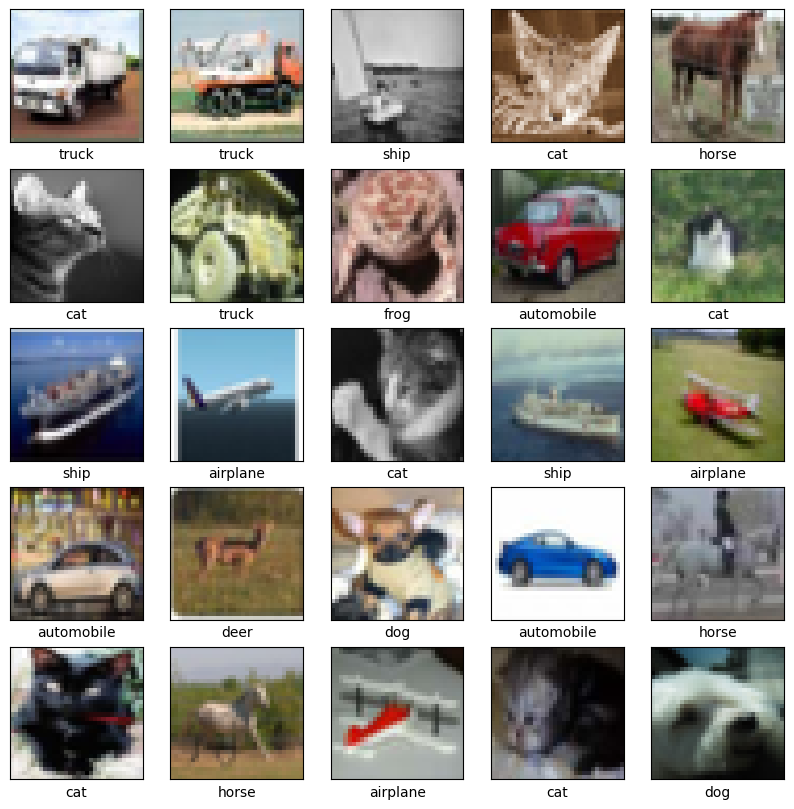

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Fetch the first batch of images and labels

# Plotting 25 images from the batch in a 5x5 grid
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.grid(False)
    img = images[i].permute(1, 2, 0)  # Reorder dimensions to (H, W, C) for display
    print(img.shape)
    plt.imshow(img)  # Display the image
    plt.xlabel(class_names[labels[i]])  # Add label as class name
plt.show()

In [7]:
#define model
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Convolutional layer
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # Max pooling layer
    nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Convolutional layer
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # Max pooling layer
    nn.Flatten(),  # Flatten the tensor for the fully connected layer
    nn.Linear(64 * 8 * 8, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Linear(128, 10)  # Output layer
)

# Initialize the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
try:
    X_train = torch.stack([item[0] for item in train_dataset]).to(device)
    y_train = torch.tensor([item[1] for item in train_dataset], dtype=torch.long, device=device)
    X_valid = torch.stack([item[0] for item in valid_dataset]).to(device)
    y_valid = torch.tensor([item[1] for item in valid_dataset], dtype=torch.long, device=device)
    preload_success = True
    print(f"Preloaded datasets to {device}. Train: {X_train.shape}, Valid: {X_valid.shape}")
except RuntimeError as e:
    preload_success = False
    print("Preloading to GPU failed (likely OOM). Falling back to per-batch transfers. Error:", e)


Preloaded datasets to cuda. Train: torch.Size([45000, 3, 32, 32]), Valid: torch.Size([5000, 3, 32, 32])


In [ ]:
def create_model(hidden_size_conv, padding,stride,kernel_size ,pool_kernel, learning_rate, optimi):
    conv_layers = []
    in_ch = 3
    for _ in range(hidden_size_conv):
        conv_layers += [
            nn.Conv2d(in_ch, 32, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel)
        ]
        in_ch = 32

    conv_seq = nn.Sequential(*conv_layers)

    # Infer flattened feature size by running a dummy tensor through conv_seq
    with torch.no_grad():
        dummy = torch.zeros(1, 3, 32, 32)  # CIFAR-10 image size
        conv_out = conv_seq(dummy)
        flatten_size = conv_out.view(1, -1).size(1)

    # Build classifier using the inferred flatten_size
    m = nn.Sequential(
        conv_seq,
        nn.Flatten(),
        nn.Linear(flatten_size, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

    # Choose optimizer
    if optimi == 'sgd':
        optimizer = optim.SGD(m.parameters(), lr=learning_rate)
    elif optimi == 'adam':
        optimizer = optim.Adam(m.parameters(), lr=learning_rate)
    elif optimi == 'adamw':
        optimizer = optim.AdamW(m.parameters(), lr=learning_rate, weight_decay=1e-4)
    else:
        optimizer = optim.Adam(m.parameters(), lr=learning_rate)

    return m, optimizer

In [37]:
# Move model to the selected device (GPU or CPU)
def train_and_val(model, optimizer):
    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer
    # Initialize lists to store metrics
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Training loop
    epochs = 200
    batch_size = 64

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        correct = 0
        total = 0
        running_loss = 0.0


        if preload_success:
                # Shuffle indices on device and iterate by slicing (no per-batch .to calls)
                perm = torch.randperm(X_train.size(0), device=device)
                for i in range(0, X_train.size(0), batch_size):
                    idx = perm[i:i+batch_size]
                    X_batch = X_train[idx]
                    y_batch = y_train[idx]

                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == y_batch).sum().item()
                    total += y_batch.size(0)
        else:
            # Fallback: transfer batches to device as before (use pin_memory in DataLoader for speed)
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        train_epoch_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(train_epoch_loss)


        # Validation step
        model.eval()  # Set model to evaluation mode
        val_running = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            if preload_success:
                for i in range(0, X_valid.size(0), batch_size):
                    X_val = X_valid[i:i+batch_size]
                    y_val = y_valid[i:i+batch_size]
                    val_outputs = model(X_val)
                    val_loss = criterion(val_outputs, y_val)
                    val_running += val_loss.item()
                    _, val_predicted = torch.max(val_outputs, 1)
                    val_correct += (val_predicted == y_val).sum().item()
                    val_total += y_val.size(0)
            else:
                for X_val, y_val in valid_loader:
                    X_val, y_val = X_val.to(device, non_blocking=True), y_val.to(device, non_blocking=True)
                    val_outputs = model(X_val)
                    val_loss = criterion(val_outputs,y_val)
                    val_running += val_loss.item()
                    _, val_predicted = torch.max(val_outputs, 1)
                    val_correct += (val_predicted == y_val).sum().item()
                    val_total += y_val.size(0)
        
        val_epoch_loss = val_running / len(valid_loader)            
        val_accuracy = val_correct / val_total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_accuracy)


        
        return train_epoch_loss, val_epoch_loss, train_accuracy, val_accuracy 
        
        

In [44]:
train_epoch_loss, val_epoch_loss, train_accuracy, val_accuracy = train_and_val(model, optimizer)

In [ ]:
from tqdm import tqdm
import pandas as pd
hidden_sizes_conv = [1, 2, 3, 4, 5]
hidden_sizes = [1, 2, 3, 4, 5]
shape = [16,32,64]
stride = [1,2,3]
padding = [0,1,2]
learning_rates = [0.01, 0.001, 0.0001]
optimizers = ['sgd', 'adam', 'adamw']
models = pd.DataFrame(columns=['model', 'train_error', 'val_error', 'train_acc', 'val_acc', 'optimizer', 'lr', 'hidden_size', 'shape'])
total_iterations = len(hidden_sizes) * len(shape) * len(learning_rates) * len(optimizers)

with tqdm(total=total_iterations, desc="Training Models") as pbar:
    for a in hidden_sizes_conv:
        for b in stride:
            for c in learning_rates:
                for e in padding:
                    for d in optimizers:
                        model, optimizer = create_model(a, e, b, 3, 3, c, 16, d)
                        model.to(device)
                        m_name = f'model_h{a}_s{b}_lr{c}_{d}'
                        pbar.set_postfix_str(f"Running {m_name}")   # <-- replaces print()
                        t_loss, v_loss, t_acc, v_acc = train_and_val(model, optimizer)
                        models.loc[len(models)] = [m_name, t_loss, v_loss, t_acc, v_acc,  d, c, a, b]
                        pbar.update(1)


Training Models:  80%|████████  | 108/135 [05:31<01:22,  3.07s/it, Running model_h2_s1_lr0.0001_adamw]


RuntimeError: Given input size: (32x2x2). Calculated output size: (32x0x0). Output size is too small

In [51]:
models.sort_values('val_acc', ascending=False)

,model,train_error,val_error,train_acc,val_acc,optimizer,lr,hidden_size,shape
17,model_h1_s1_lr0.001_adamw,1.552249,1.275822,0.446467,0.5496,adamw,0.0010,1,1
16,model_h1_s1_lr0.001_adam,1.551158,1.306808,0.444867,0.5388,adam,0.0010,1,1
13,model_h1_s1_lr0.001_adam,1.545188,1.310704,0.447644,0.5366,adam,0.0010,1,1
10,model_h1_s1_lr0.001_adam,1.582379,1.350173,0.433822,0.5198,adam,0.0010,1,1
5,model_h1_s1_lr0.01_adamw,1.600140,1.362440,0.425044,0.5172,adamw,0.0100,1,1
...,...,...,...,...,...,...,...,...,...
90,model_h2_s1_lr0.001_sgd,2.302552,2.301654,0.101422,0.0976,sgd,0.0010,2,1
72,model_h1_s3_lr0.0001_sgd,2.305724,2.306866,0.100956,0.0964,sgd,0.0001,1,3
96,model_h2_s1_lr0.001_sgd,2.300818,2.300571,0.101044,0.0912,sgd,0.0010,2,1
93,model_h2_s1_lr0.001_sgd,2.303826,2.303778,0.091644,0.0912,sgd,0.0010,2,1


In [41]:
best_idx = models['val_acc'].idxmax()
best_row = models.loc[best_idx]

In [42]:
best_row

model          model_h1_s1_lr0.001_adamw
train_error                     1.552249
val_error                       1.275822
train_acc                       0.446467
val_acc                           0.5496
optimizer                          adamw
lr                                 0.001
hidden_size                            1
shape                                  1
Name: 17, dtype: object

In [ ]:
best_idx = models['val_acc'].idxmax()
best_row = models.loc[best_idx]

best_hidden = int(best_row['hidden_size'])
best_lr = float(best_row['lr'])
best_shape = int(best_row['shape'])
best_opt = best_row['optimizer']
best_name = best_row['model']


best_model, best_optimizer = create_model(best_hidden, best_padding, best_stride, best_kernel_size, best_pool_kernel, best_lr, best_opt)
best_model.to(device)

# retrain with verbose=True to collect per-epoch losses (returns DataFrame)
loss_df = train_and_val(best_model, best_optimizer, model_name=best_row['model'], num_epochs=180, verbose=True)

# plot
plt.figure(figsize=(8,5))
plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df['epoch'], loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Train vs Val Loss for best model: {best_name}')
plt.legend()
plt.show()

TypeError: create_model() missing 5 required positional arguments: 'kernel_size', 'pool_kernel', 'learning_rate', 'shape', and 'optimi'

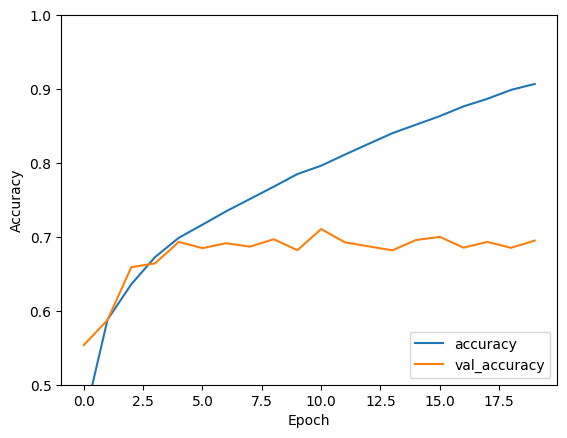

In [ ]:
# Plot the accuracies
plt.plot(train_accuracies, label='accuracy')
plt.plot(val_accuracies, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()